# This script is to test BNE UHI from the ERA5 data
* Likely see some anthropogenic signal maybe
* Also averaging all years might show seasonal cycle - that is different for different cities?

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from pathlib import Path
import glob
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cf
states_provinces = cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none')
import string  
lower = list(string.ascii_lowercase)  
capital = list(string.ascii_uppercase)  

In [2]:
import healpy as hp
import easygems.healpix as egh
import osmnx as ox
import geopandas as gpd 
from geopy.distance import geodesic
import intake
from cartopy.io import shapereader as shpreader
from cartopy.feature import ShapelyFeature
from shapely.geometry import MultiPolygon, Polygon, Point
from rasterio import features


In [3]:
path_era='/g/data/rt52/era5/single-levels/reanalysis/'
path_um='/g/data/qx55/uk_node/glm.n2560_RAL3p3/'
plot_path='/home/561/dc5055/WCRP_HK25/Plots'

In [75]:
var='2t'
varname_era='t2m'

In [57]:
city_name='Brisbane'
city_lat = float('-27.47')
city_lon = float('153.03') 
rat_buff=3 # Ratio of buffer radius to max city radius

### Landmask

In [61]:
file_land=sorted(Path(path_era).glob(f'lsm/*/*.nc'))
ds_land=xr.open_mfdataset(file_land[0], chunks=-1)
lsm=ds_land['lsm'][0]

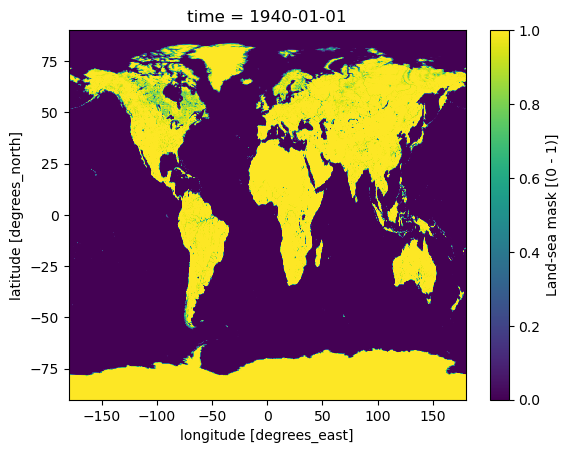

In [63]:
# lsm.plot()

In [9]:
file_era=sorted(Path(path_era).glob(f'{var}/*/*.nc'))
list(file_era)
ds_era=xr.open_mfdataset(file_era, chunks=-1)[varname_era][3:][::24]
# ds_era

<xarray.DataArray 't2m' (time: 31078, latitude: 721, longitude: 1440)> Size: 258GB
dask.array<getitem, shape=(31078, 721, 1440), dtype=float64, chunksize=(31, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 249kB 1940-01-01T03:00:00 ... 2025-01-31...
Attributes:
    units:      K
    long_name:  2 metre temperature

### Subsetting area around city for faster processing
* Notice latitude slicing needs to be counterintuitive

In [64]:
var_era=ds_era.where(lsm>0).sel(longitude=slice(city_lon-5, city_lon+5), latitude=slice(city_lat+5, city_lat-5))

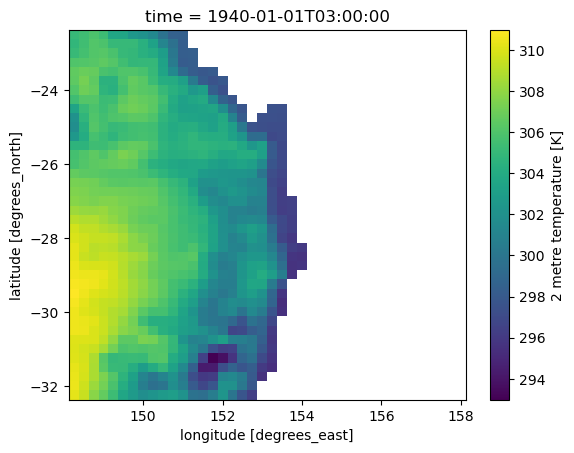

In [65]:
var_era[0].plot()

## Function to subset city

### Function to create circle

In [49]:
def create_circle(center_lat, center_lon , radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    circle_lats, circle_lons = [], []
    for angle in angles:
        dest = geodesic(kilometers=radius_km).destination((center_lat, center_lon), angle)
        circle_lats.append(dest.latitude)
        circle_lons.append(dest.longitude)
    return circle_lons, circle_lats


### Masking city, buffer and UHI

In [77]:
def uhi(var_era, rat_buff):
    gdf = ox.geocode_to_gdf(city_name)
    geom = gdf.loc[0, 'geometry']
    # If it's a MultiPolygon, get the largest one by area
    if isinstance(geom, MultiPolygon):
        city_poly = max(geom.geoms, key=lambda a: a.area)
    elif isinstance(geom, Polygon):
        city_poly = geom
    else:
        raise TypeError("Geometry is not a Polygon or MultiPolygon")
    gdf_city = gpd.GeoDataFrame(index=[0], geometry=[city_poly], crs=gdf.crs)
    gdf_city_proj = gdf_city.to_crs(epsg=3857) 
    geom_city = gdf_city_proj.geometry[0]
    # city_geometry = geom_city.geometry.iloc[0]  # Extract the first geometry
    
    # Computing max radius and centroid
    centroid_city=city_poly.centroid
    boundary_coords = np.array(city_poly.exterior.coords)
    distances_m = [
        geodesic((centroid_city.y, centroid_city.x), (lat, lon)).meters
        for lon, lat in boundary_coords  # coords = (lon, lat)
    ]
    radius_m = max(distances_m)
    radius_km = radius_m / 1000
    center_lat, center_lon = centroid_bne.y, centroid_bne.x
    print(f"Area of city: {geom_city.area/1e6:.2f} km²")
    print(f"Radius of city: {radius_km:.2f} km")

# Masking points inside city polygon
    print(f'Calculating mask and values over city area')
    tmp = var_era.rio.write_crs("EPSG:4326", inplace=True)
    tmp = tmp.rename({'longitude':'x', 'latitude':'y'})
    gdf = gdf.to_crs(tmp.rio.crs)
    
    lat_2d, lon_2d = xr.broadcast(var_era['latitude'], var_era['longitude'])
    mask_land_2d=~np.isnan(var_era[0].values)
    land_lons = lon_2d.values[mask_land_2d]
    land_lats = lat_2d.values[mask_land_2d]
    points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(land_lons, land_lats)], crs="EPSG:4326")
    inside_city = points.within(city_poly)
    pts_inside_city = points[inside_city]

    mask = features.rasterize(
        [(geom, 1) for geom in gdf_city["geometry"]],
        out_shape=tmp.rio.shape,
        transform=tmp.rio.transform(),
        fill=0,
        dtype='uint8'
    )
    
    mask_city = xr.DataArray(mask, dims=("latitude", "longitude"), 
                             coords={"latitude": tmp.y.values, "longitude": tmp.x.values})
    var_city = var_era.where(mask_city == 1)   # this is masking 

# Masking points inside buffer zone but outside city polygon
    print(f'Calculating mask and values over buffer ({rat_buff * radius_km:.2f} km circle) minus city area')
    rad_buff = rat_buff * radius_km
    buff_circle_lons, buff_circle_lats = create_circle(center_lat, center_lon, rad_buff)
    buff_circle_polygon = Polygon(zip(buff_circle_lons, buff_circle_lats))  # For masking
    
    gdf_buff = gpd.GeoDataFrame(index=[0], geometry=[buff_circle_polygon], crs=gdf.crs)
    mask = features.rasterize(
        [(geom, 1) for geom in gdf_buff["geometry"]],
        out_shape=tmp.rio.shape,
        transform=tmp.rio.transform(),
        fill=0,
        dtype='uint8'
    )
    
    mask_buff_circle = xr.DataArray(mask, dims=("latitude", "longitude"), 
                                    coords={"latitude": tmp.y.values, "longitude": tmp.x.values})
    var_buff = var_era.where((mask_buff_circle == 1) & (mask_city == 0))   # this is masking 

    uhi_timeseries = var_city.mean(('latitude', 'longitude'))-var_buff.mean(('latitude', 'longitude'))
    print(f'Finished calculating timeseries of UHI over {city_name} for {varname_era}')
    return uhi_timeseries, var_city, var_buff, rad_buff

In [70]:
uhi_timeseries, var_city, var_buff, rad_buff=uhi(var_era, rat_buff)

Area of city: 1520.48 km²
Radius of city: 33.14 km
Calculating mask and values over city area
Calculating mask and values over buffer (99.41356288458697 km circle) minus city area


In [78]:
# rad_buff

99.41356288458697

In [76]:
# uhi_timeseries#.time

<xarray.DataArray 't2m' (time: 31078)> Size: 249kB
dask.array<sub, shape=(31078,), dtype=float64, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 249kB 1940-01-01T03:00:00 ... 2025-01-...
    spatial_ref  int64 8B 0

KeyboardInterrupt: 

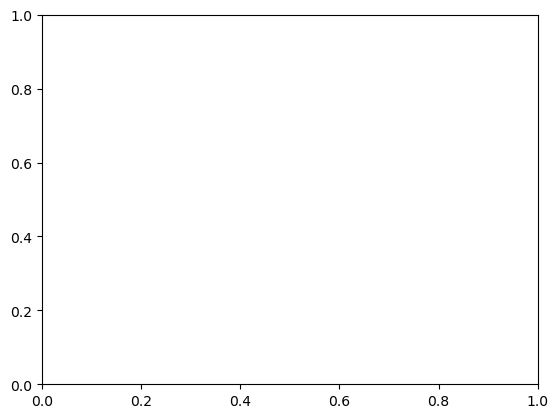

In [71]:
plt.plot(uhi_timeseries)

### Timeseries of Var plot and buffer + UHI

In [ ]:
fig=plt.figure(figsize=(12, 8))

ax1=plt.subplot(211)
# Might add something to remove 273.15 from temperature data in Kelvins
ax1.grid(alpha=0.3)
(var_city.mean(dim=('latitude','longitude'))).plot(ax=ax1, color='blue', label='City polygon')
(var_buff.mean(dim=('latitude','longitude'))).plot(ax=ax1, color='grey', label='Buffer (r=%.0f km)' %(rad_buff))
plt.title(f"Hrly {varname_era} at 1pm local time around {city_name}")
# plt.ylabel('TS (˚C)')
plt.xlabel('')
plt.legend()

ax2=plt.subplot(212)
ax2.grid(alpha=0.3)
(uhi_timeseries).plot(ax=ax2, linewidth=0.5, linestyle='--', marker='o',color='r', label='UHI')
plt.ylabel(f'{varname_era} UHI: Poly - Buff ({rat_buff} x city_rad)', color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.title(f"Urban Heat Island effect on {varname_era} ")

os.chdir('%s' %(plot_path))
plt.savefig(f'Timeseries_{varname_era}_{city_name}_UHI.png', dpi=200, bbox_inches='tight')

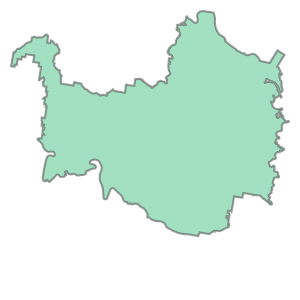

In [44]:
# geom_city

## Testing

### Masking points inside city polygon

In [51]:
lat_2d, lon_2d = xr.broadcast(var_era['latitude'], var_era['longitude'])
mask_land_2d=~np.isnan(var_era[0].values)
land_lons = lon_2d.values[mask_land_2d]
land_lats = lat_2d.values[mask_land_2d]
points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(land_lons, land_lats)], crs="EPSG:4326")
inside_city = points.within(city_poly)
pts_inside_city = points[inside_city]

In [52]:
tmp = var_era.rio.write_crs("EPSG:4326", inplace=True)
tmp = tmp.rename({'longitude':'x', 'latitude':'y'})
gdf = gdf.to_crs(tmp.rio.crs)

In [54]:
mask = features.rasterize(
    [(geom, 1) for geom in gdf_city["geometry"]],
    out_shape=tmp.rio.shape,
    transform=tmp.rio.transform(),
    fill=0,
    dtype='uint8'
)

mask_city = xr.DataArray(mask, dims=("latitude", "longitude"), 
                         coords={"latitude": tmp.y.values, "longitude": tmp.x.values})
var_city = var_era.where(mask_city == 1)   # this is masking 

In [66]:
var_city[0]#.plot()

<xarray.DataArray 't2m' (latitude: 40, longitude: 40)> Size: 13kB
dask.array<getitem, shape=(40, 40), dtype=float64, chunksize=(40, 40), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float32 160B 148.2 148.5 148.8 ... 157.8 158.0
  * latitude     (latitude) float32 160B -22.5 -22.75 -23.0 ... -32.0 -32.25
    time         datetime64[ns] 8B 1940-01-01T03:00:00
    spatial_ref  int64 8B 0
Attributes:
    units:      K
    long_name:  2 metre temperature

### Getting buffer zone

In [58]:
rad_buff = rat_buff * radius_km
buff_circle_lons, buff_circle_lats = create_circle(center_lat, center_lon, rad_buff)
buff_circle_polygon = Polygon(zip(buff_circle_lons, buff_circle_lats))  # For masking

gdf_buff = gpd.GeoDataFrame(index=[0], geometry=[buff_circle_polygon], crs=gdf.crs)
mask = features.rasterize(
    [(geom, 1) for geom in gdf_buff["geometry"]],
    out_shape=tmp.rio.shape,
    transform=tmp.rio.transform(),
    fill=0,
    dtype='uint8'
)

mask_buff_circle = xr.DataArray(mask, dims=("latitude", "longitude"), 
                                coords={"latitude": tmp.y.values, "longitude": tmp.x.values})
var_buff = var_era.where((mask_buff_circle == 1) & (mask_city == 0))   # this is masking 

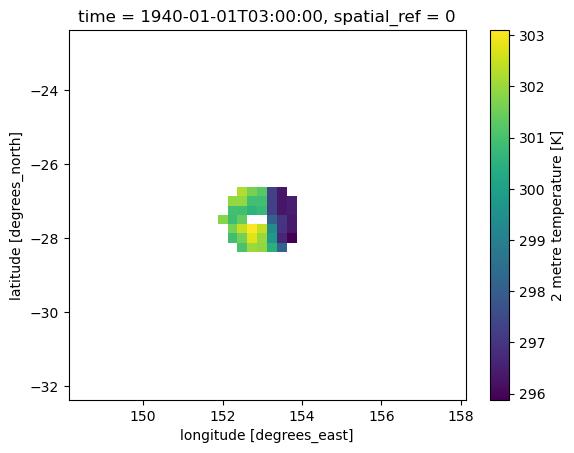

In [59]:
var_buff[0].plot()